# Shared Bike Predictions

## Business Objectives

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

## Data Overview

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, adjusted_rand_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [2]:
# Lets read the file into pandas dataframe and gather its shape(rows, columns)
df = pd.read_csv('day.csv', date_parser=True)
df.shape

(730, 16)

In [3]:
# let see the data types of columns spread out
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
# Let's eye-on the data to understand the data types and whether it requires any modification for our analysis
df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


We can see data looks clean, only dteday needs to be changed to datetime object

In [5]:
# Lets now gather information of no of nan data across columns
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# From the business objective we are aware, we have to predict the demand for the shared bikes.
# From the given dictionary, we can understand the column that illustrates these characteristics is 'cnt'
df.cnt.describe()

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64

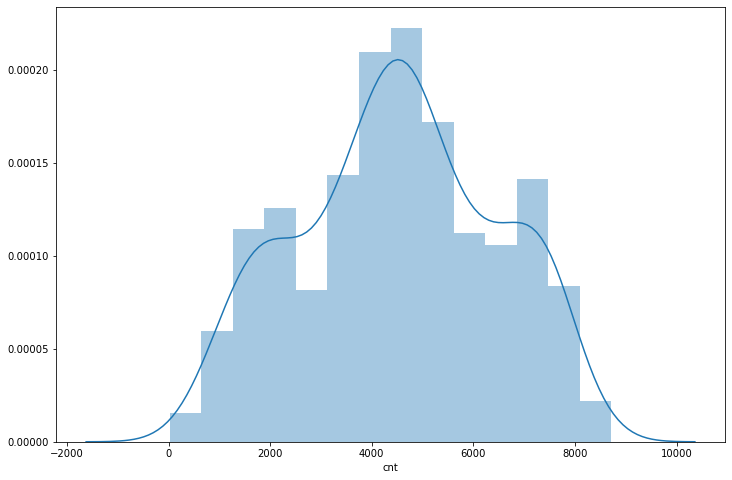

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(df.cnt)
plt.show()

Since, cnt is normally distributed no need transformation like log or squarred

## Cleaning Data and Extracting new features

In [10]:
# pre-processing features: converting dteday to date time object
df['dteday'] = pd.to_datetime(df['dteday'])

In [11]:
# Let's fetch day and week_of_year
df['week_of_year'] = df['dteday'].apply(lambda x: x.week)
df['day'] = df['dteday'].apply(lambda x: x.day)

In [12]:
# Let's identify which fetures doesn't play any role
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'week_of_year', 'day'],
      dtype='object')

In [13]:
drop_features = ["instant",  "dteday"]

In [14]:
# Dropping unwanted columns
df.drop(drop_features, inplace=True, axis=1)
df.reset_index(drop=True, inplace=True)
df.shape

(730, 16)

In [15]:
df['casual'] = df.casual.astype(float)
df['registered'] = df.registered.astype(float)

Now we are all set to do analysis that helps in predicting the important factors

## Univariate Analysis

In [16]:
# Finding info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        730 non-null    int64  
 1   yr            730 non-null    int64  
 2   mnth          730 non-null    int64  
 3   holiday       730 non-null    int64  
 4   weekday       730 non-null    int64  
 5   workingday    730 non-null    int64  
 6   weathersit    730 non-null    int64  
 7   temp          730 non-null    float64
 8   atemp         730 non-null    float64
 9   hum           730 non-null    float64
 10  windspeed     730 non-null    float64
 11  casual        730 non-null    float64
 12  registered    730 non-null    float64
 13  cnt           730 non-null    int64  
 14  week_of_year  730 non-null    int64  
 15  day           730 non-null    int64  
dtypes: float64(6), int64(10)
memory usage: 91.4 KB


In [17]:
df.tail()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,week_of_year,day
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247.0,1867.0,2114,52,27
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644.0,2451.0,3095,52,28
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159.0,1182.0,1341,52,29
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364.0,1432.0,1796,1,30
729,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439.0,2290.0,2729,1,31


### temp

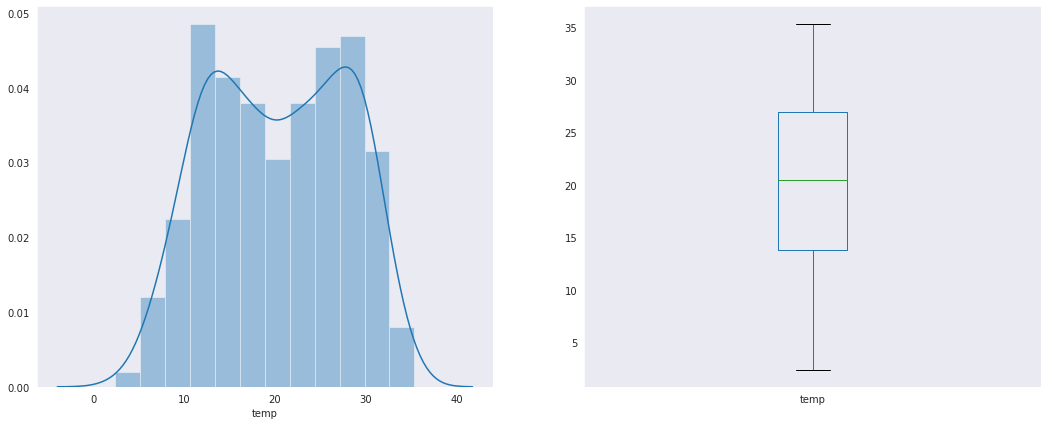

In [18]:
# Plotting temp to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['temp']);

plt.subplot(122)
df['temp'].plot.box()

plt.show()

The data is doube normal distributed but with no outliers and seems good for the analysis

### atemp

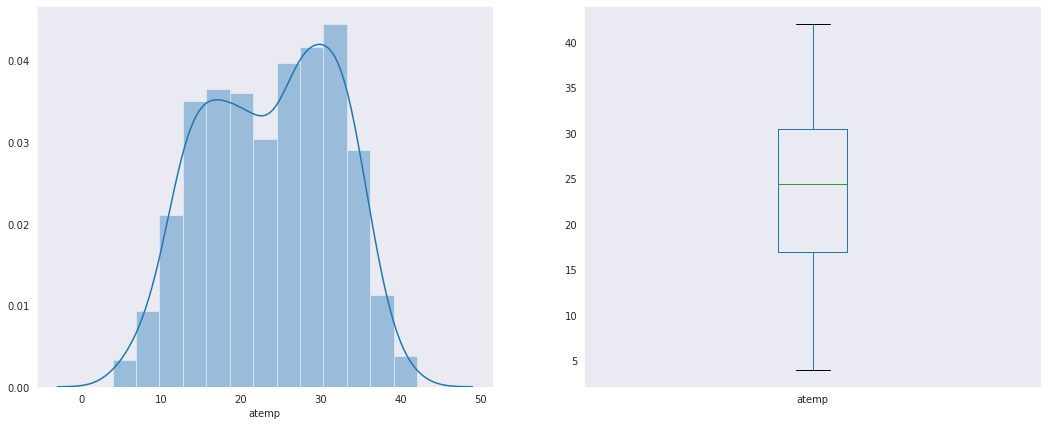

In [19]:
# Plotting atemp to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['atemp']);

plt.subplot(122)
df['atemp'].plot.box()

plt.show()

similarly, This data is also doube normal distributed but with no outliers and seems good for the analysis

### hum

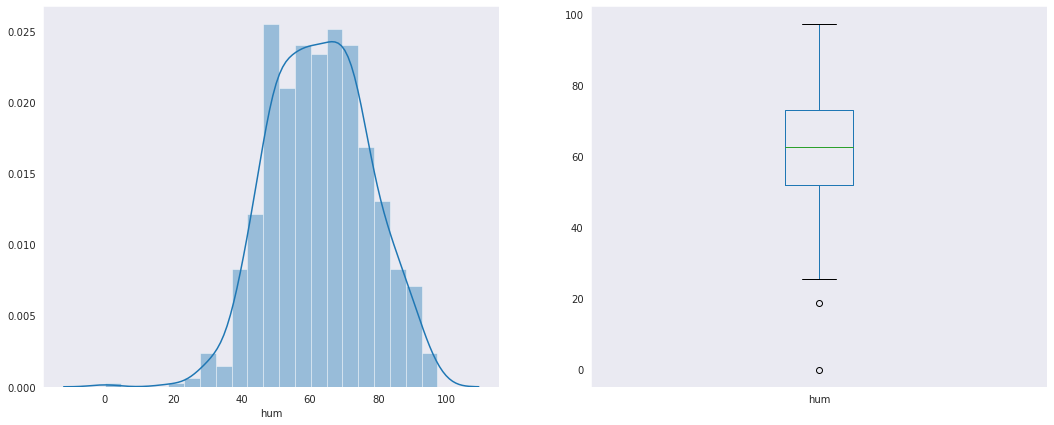

In [20]:
# Plotting hum to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['hum']);

plt.subplot(122)
df['hum'].plot.box()

plt.show()

The data is normal distributed but with 2 outliers and seems good for the analysis

### windspeed

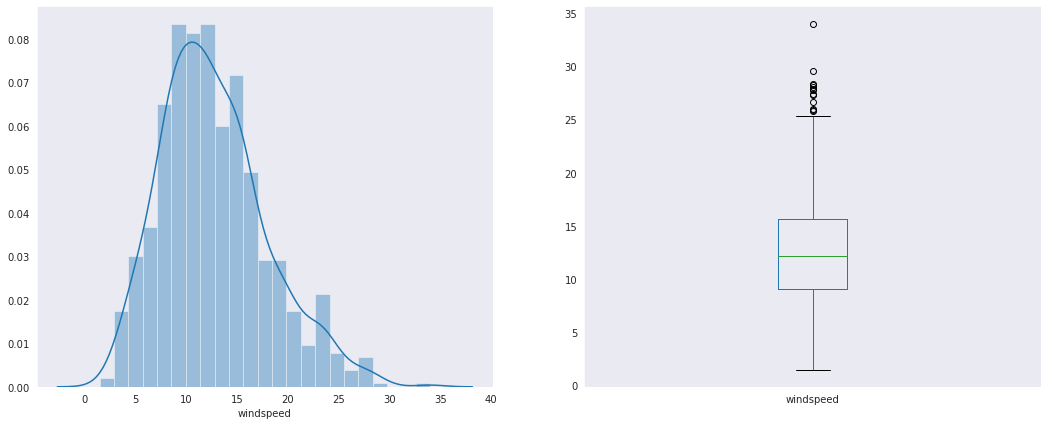

In [22]:
# Plotting windspeed to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['windspeed']);

plt.subplot(122)
df['windspeed'].plot.box()

plt.show()

The data is normal distributed but tail at the right side having fewer outliers

### casual

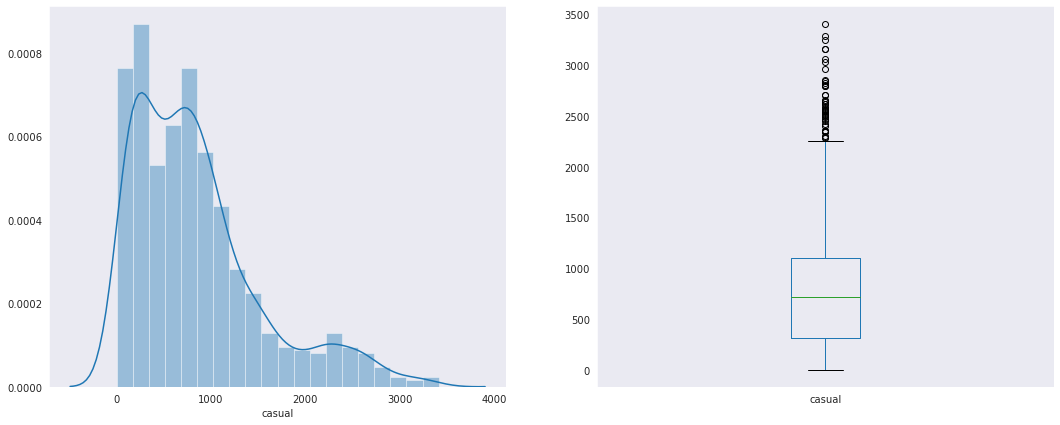

In [23]:
# Plotting casual to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['casual']);

plt.subplot(122)
df['casual'].plot.box()

plt.show()

The data is right skewed normal distributed having outliers and requires treatement for model building

### registered

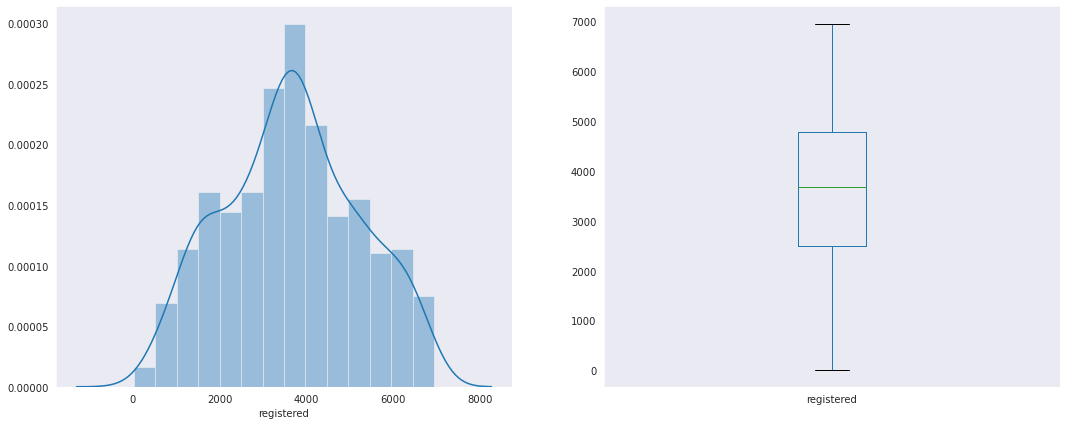

In [24]:
# Plotting registered inv to see how the data is spread

plt.figure(figsize = (18,7))
sns.set_style("dark")

plt.subplot(121)
sns.distplot(df['registered']);

plt.subplot(122)
df['registered'].plot.box()

plt.show()

The data is normal distributed and seems good for the analysis

### holiday

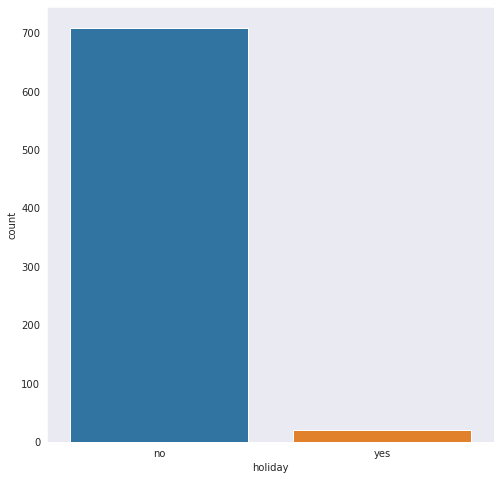

In [34]:
# Frequency distribution of holiday

plt.figure(figsize = (8,8))
plot_df = df.copy()
plot_df['holiday'] = plot_df.holiday.map({0:'no', 1:'yes'})
sns.countplot(x="holiday", data=plot_df)
plt.show()

5% of data constitutes of holiday

In [26]:
df.holiday.value_counts()/ df.holiday.value_counts().sum()

0    0.971233
1    0.028767
Name: holiday, dtype: float64

### season

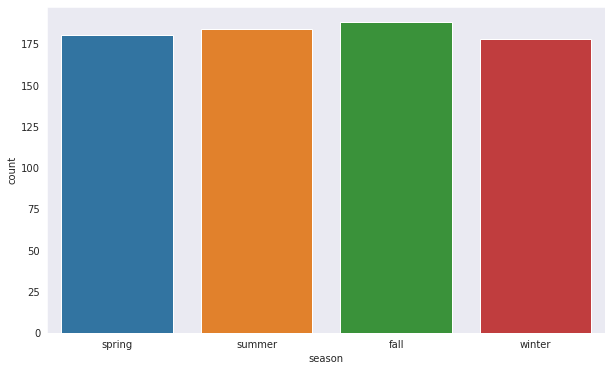

In [35]:
# Frequency distribution of season

plt.figure(figsize = (10,6))
plot_df['season'] = plot_df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
sns.countplot(x="season", data=plot_df)
plt.show()

data is evenly spread across all seasons

In [28]:
df.season.value_counts()/ df.season.value_counts().sum()

3    0.257534
2    0.252055
1    0.246575
4    0.243836
Name: season, dtype: float64

### weathersit

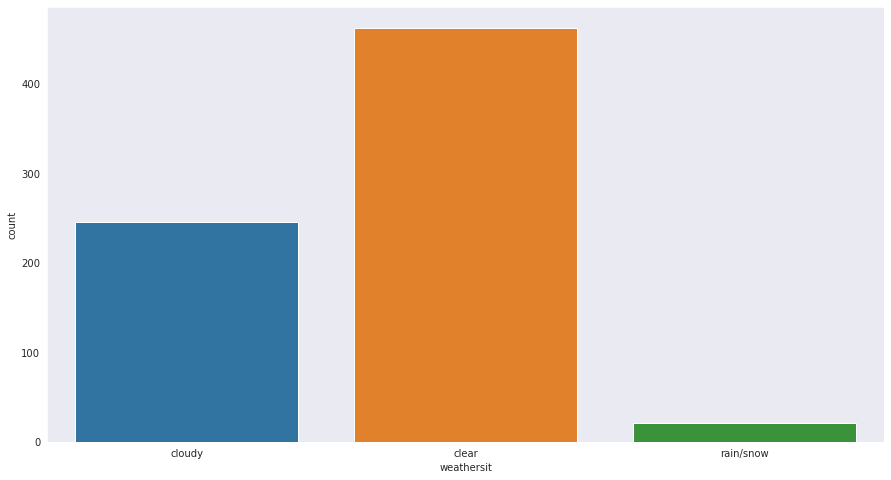

In [36]:
# Frequency distribution of weathersit

plt.figure(figsize = (15,8))
plot_df['weathersit'] = plot_df.weathersit.map({1:'clear', 2:'cloudy', 3:'rain/snow', 4:'heavy rain/snow'})
sns.countplot(x="weathersit", data=plot_df)
plt.show()

In [37]:
df.weathersit.value_counts()/ df.weathersit.value_counts().sum()

1    0.634247
2    0.336986
3    0.028767
Name: weathersit, dtype: float64

We can see close to 65% of the time it's clear sky and 33% of the time it's cloudy and 2% of the time its rainy

## Bi-variate Analysis

In [38]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'week_of_year', 'day'],
      dtype='object')

In [39]:
# Feature Engineering to see demand over years

df["year_mnth"] = pd.Series(df["yr"].astype(str) + df["mnth"].astype(str)).astype(str)
df["year_mnth"] = df.year_mnth.apply(lambda x: x.lstrip('0'))
ym_cntsum = df.groupby(['year_mnth'])['cnt'].agg(['sum']).reset_index()
ym_cntsum.rename(columns={'sum': 'ym_cntsum'}, inplace=True)
df = pd.merge(df, ym_cntsum, how = 'left', left_on = ['year_mnth'], right_on = ['year_mnth'])

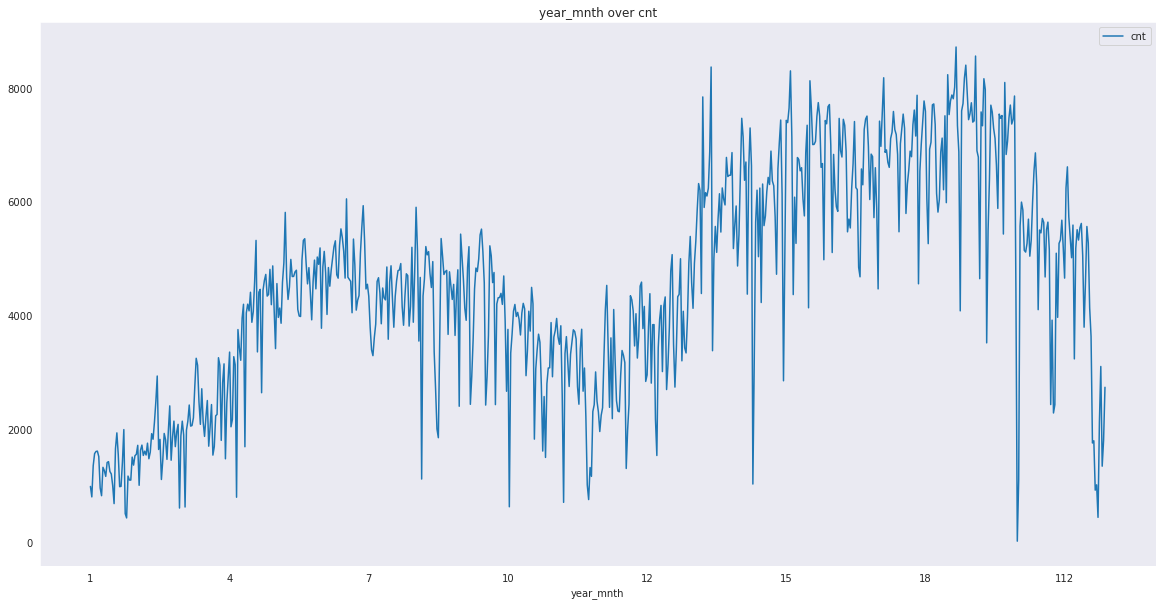

In [40]:
df.plot(x='year_mnth', y='cnt', figsize=(20,10), title='year_mnth over cnt')
plt.show()

If we see, there is a pattern seen in the beginning of the year and close to end of the year and thats a drop in the demand that may be because of the season, temp, humidity. Let's see that in detail in next analysis

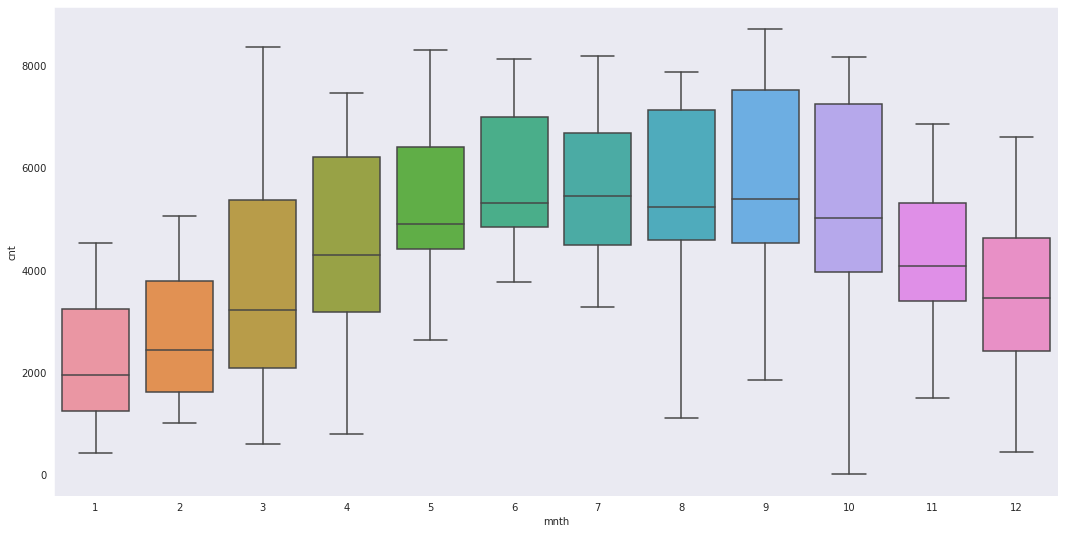

In [41]:
# Relation of mnth with cnt

plt.figure(figsize = (18, 9))
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.show()

Over months for both the years the same pattern is found. 

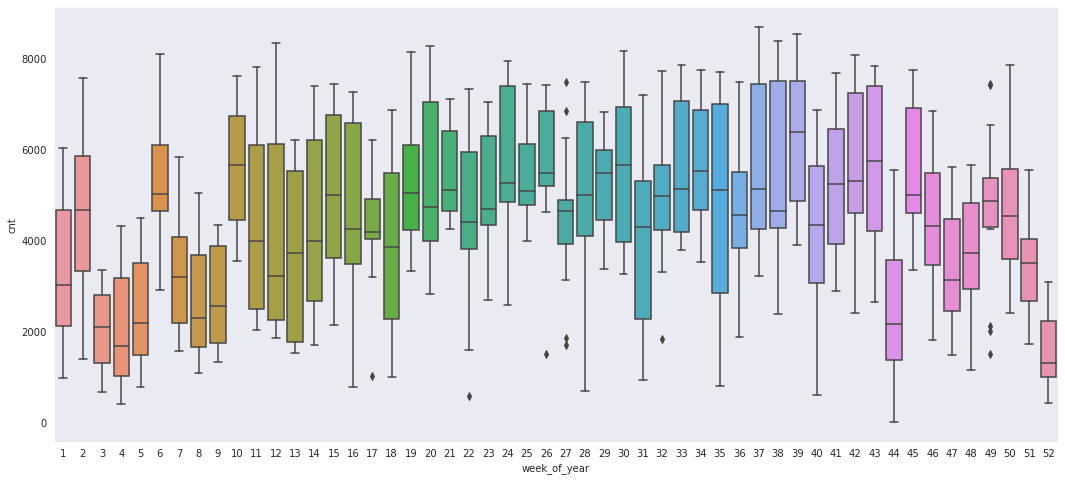

In [43]:
# Relation of week_of_year with cnt

plt.figure(figsize = (18, 8))
sns.boxplot(x = 'week_of_year', y = 'cnt', data = df)
plt.show()

If not clear something very similar pattern can be seen across of week_of_year feature as well.

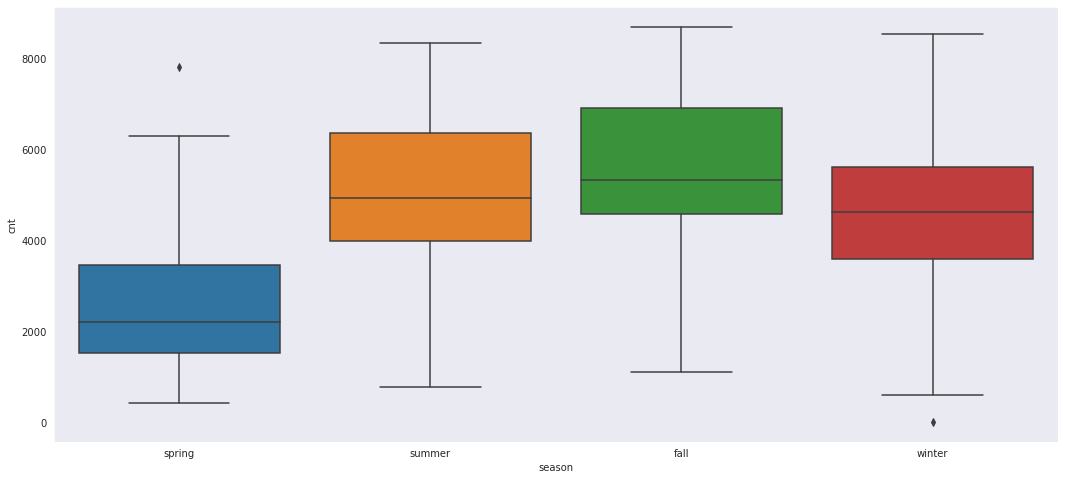

In [121]:
# Relation of season with cnt

plt.figure(figsize = (18, 8))
sns.boxplot(x = 'season', y = 'cnt', data = plot_df)
plt.show()

Over seasons we can see the same pattern is found. the demnand seems to be high in summer and spring.

In [45]:
continous_features = df.columns[df.dtypes==float]
continous_features

Index(['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'], dtype='object')

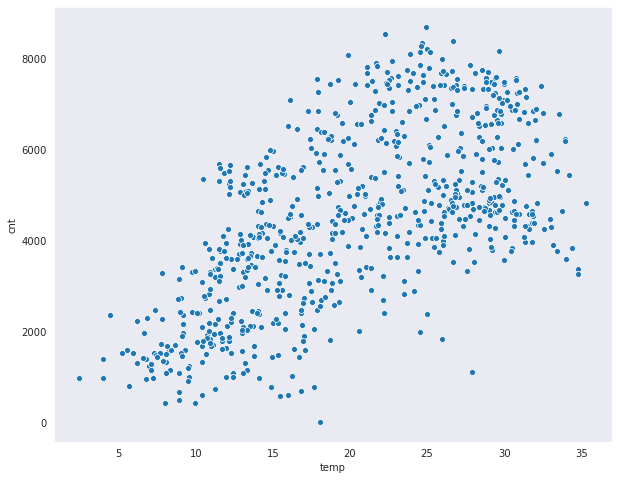

In [46]:
# relation of temp over cnt

plt.figure(figsize = (10,8))
sns.set_style("dark")
sns.scatterplot(df.temp, df.cnt)

plt.show()

In [47]:
df.corr()['temp']['cnt']

0.6270440344135152

We can see here, there is 62% correlation between temp and cnt

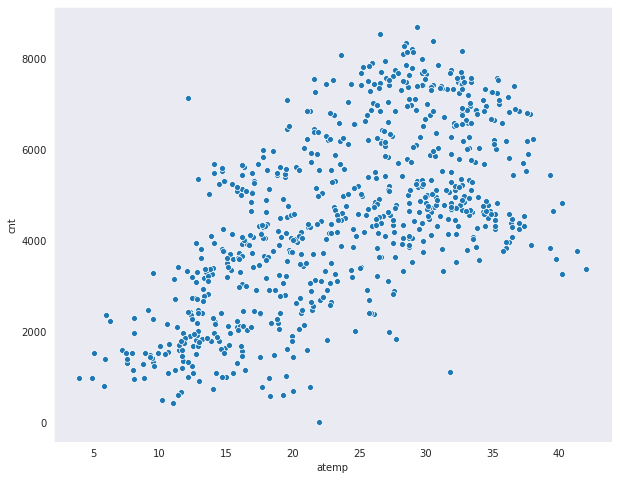

In [48]:
# relation of atemp over cnt

plt.figure(figsize = (10,8))
sns.set_style("dark")
sns.scatterplot(df.atemp, df.cnt)

plt.show()

In [55]:
df.corr()['atemp']['cnt']

0.6306853489531031

We can see here, there is 63% correlation between temp and cnt. There can be a multicollinearity issues with temp and atemp as the relation and pattern seems identical

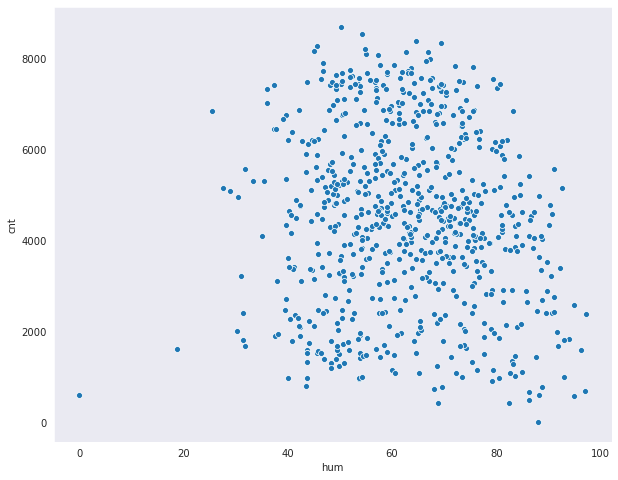

In [49]:
# relation of hum over cnt

plt.figure(figsize = (10,8))
sns.set_style("dark")
sns.scatterplot(df.hum, df.cnt)

plt.show()

In [54]:
df.corr()['hum']['cnt']

-0.09854287912248019

Though its a negative correlation, the feature doesn't potray strong relationship. Its weak.

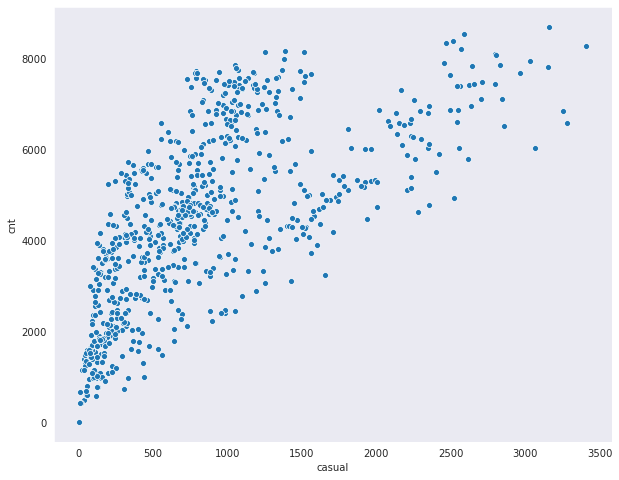

In [50]:
# relation of casual over cnt

plt.figure(figsize = (10,8))
sns.set_style("dark")
sns.scatterplot(df.casual, df.cnt)

plt.show()

In [53]:
df.corr()['casual']['cnt']

0.6721234097443962

We can see here, there is 67% correlation between casual and cnt

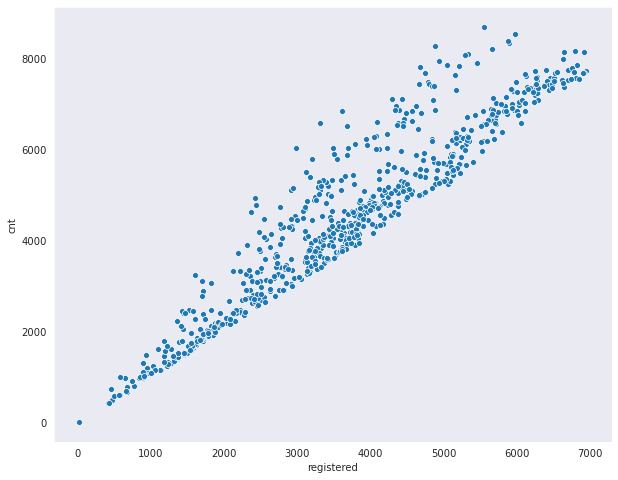

In [51]:
# relation of registered over cnt

plt.figure(figsize = (10,8))
sns.set_style("dark")
sns.scatterplot(df.registered, df.cnt)

plt.show()

In [52]:
df.corr()['registered']['cnt']

0.9454106118483713

registered is strongly correlated with cnt target variable by 94%. this is a very important feature in building our model as most of the variance is explained by this feature alone.

### Data Scaling

In [56]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'week_of_year', 'day', 'year_mnth', 'ym_cntsum'],
      dtype='object')

In [57]:
# let's drop new column created for visualization purpose
df.drop(['year_mnth', 'ym_cntsum'], axis=1, inplace=True)

In [58]:
# let's split test_set by 30% of the dataset
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1024)

In [59]:
# Applying MinMax Scalar on continous variables
scaler = MinMaxScaler()

num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'casual','registered']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [60]:
df_train.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,week_of_year,day
409,1,1,2,0,2,1,2,0.280663,0.314226,0.523136,0.244886,0.037048,0.516233,3922,7,14
592,3,1,8,0,4,1,1,0.811050,0.748108,0.533848,0.246158,0.390767,0.896018,7605,33,16
541,3,1,6,0,2,1,1,0.693922,0.666965,0.383890,0.670521,0.314025,0.911026,7442,26,26


In [61]:
df_test.head(3)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,week_of_year,day
22,1,0,1,0,0,0,1,-0.014557,-0.003813,0.448866,0.462217,0.041458,0.064319,986,4,23
605,3,1,8,0,3,1,1,0.765746,0.722467,0.567695,0.185891,0.343428,0.934763,7697,35,29
382,1,1,1,0,3,1,1,0.259668,0.234831,0.455869,0.810267,0.029403,0.436600,3376,3,18


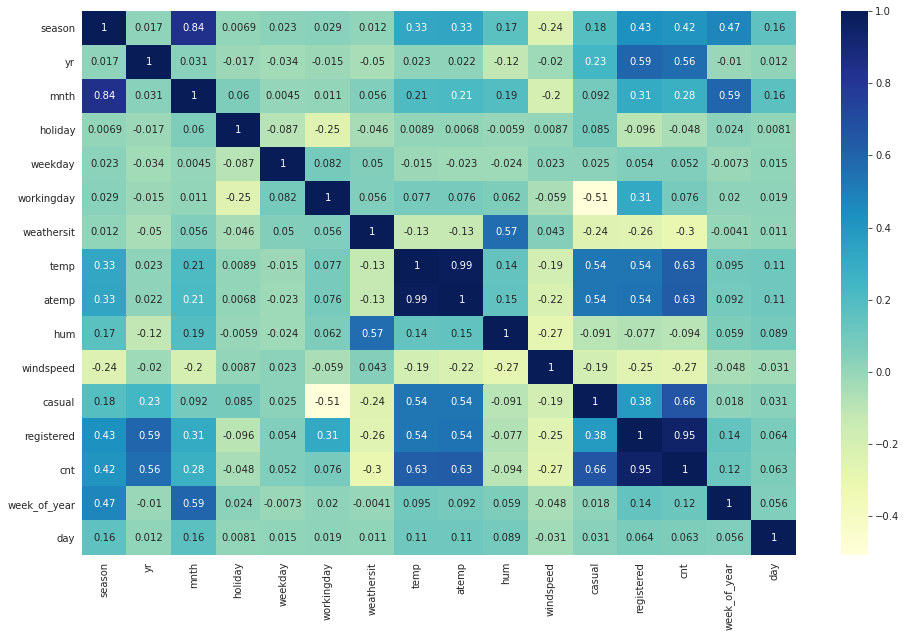

In [62]:
# Let's check the correlation coefficients to see how variables are correlated

plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

registered, temp, mnth features seems be correlated well with cnt

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [63]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_vif(vif_df):
    vif = pd.DataFrame()
    vif['Features'] = vif_df.columns
    vif['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Forward Model-Building

### Model-1

In [65]:
y_train = df_train.pop('cnt')
X_train = df_train

Model-1 built on one feature registered as it was strongly correlated with cnt

In [66]:
import statsmodels.api as sm

# Add a constant
X_train_lm = sm.add_constant(X_train[['registered']])

# Create a first fitted model
lr1 = sm.OLS(y_train, X_train_lm).fit()

In [68]:
# Check the coefficients obtained
lr1.params

const          710.459586
registered    7604.279850
dtype: float64

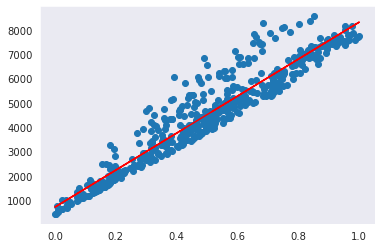

In [69]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(X_train_lm.iloc[:, 1], y_train)
plt.plot(X_train_lm.iloc[:, 1], 710.459586 + 7604.279850*X_train_lm.iloc[:, 1], 'r')
plt.show()

In [70]:
# Print a summary of the linear regression model obtained
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     4375.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          4.25e-252
Time:                        22:22:04   Log-Likelihood:                -4014.3
No. Observations:                 511   AIC:                             8033.
Df Residuals:                     509   BIC:                             8041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        710.4596     64.136     11.077      0.0

In [71]:
check_vif(X_train_lm)

,Features,VIF
0,const,5.37
1,registered,1.00


Thats a strong model with just one significant feature, with low vif and good r2_score

### Model-2

Model Built on two features registered and mnth as it was strongly correlated with cnt

In [73]:
# Assign all the feature variables to X
X_train_lm = X_train[['registered', 'mnth']]

In [74]:
# Build a linear model

X_train_lm = sm.add_constant(X_train_lm)

lr2 = sm.OLS(y_train, X_train_lm).fit()

lr2.params

const          733.027270
registered    7627.461846
mnth            -5.285160
dtype: float64

In [75]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2185.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          2.89e-250
Time:                        22:24:11   Log-Likelihood:                -4014.1
No. Observations:                 511   AIC:                             8034.
Df Residuals:                     508   BIC:                             8047.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        733.0273     73.536      9.968      0.0

In [76]:
check_vif(X_train_lm)

,Features,VIF
0,const,7.05
1,registered,1.10
2,mnth,1.10


Thats not a good model but with mnth insignificant feature

### Model-3

Model built on three features registered, yr, temp as it was correlated with cnt

In [77]:
# Assign all the feature variables to X
X_train_lm = X_train[['registered', 'yr','temp']]

In [78]:
# Build a linear model

X_train_lm = sm.add_constant(X_train_lm)

lr3 = sm.OLS(y_train, X_train_lm).fit()

lr3.params

const          359.797135
registered    6263.065004
yr             376.094722
temp          1631.047443
dtype: float64

In [79]:
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1926.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          1.15e-276
Time:                        22:29:14   Log-Likelihood:                -3948.8
No. Observations:                 511   AIC:                             7906.
Df Residuals:                     507   BIC:                             7923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        359.7971     63.832      5.637      0.0

In [80]:
check_vif(X_train_lm)

,Features,VIF
0,const,6.85
1,registered,2.68
2,yr,1.90
3,temp,1.75


Thats a strong model with all significant features and good vifs

### Model-4

Model built on 7 features after many iterations found these to be finalized 

In [82]:
# Assign all the feature variables to X
X_train_lm = X_train[['registered', 'yr','temp','windspeed','weathersit','hum','holiday']]

In [83]:
# Build a linear model

X_train_lm = sm.add_constant(X_train_lm)

lr4 = sm.OLS(y_train, X_train_lm).fit()

lr4.params

const         1237.255874
registered    5917.737486
yr             442.827525
temp          1737.057856
windspeed     -627.217910
weathersit    -156.946816
hum           -565.618365
holiday        253.241222
dtype: float64

In [84]:
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     906.7
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          1.49e-280
Time:                        22:33:13   Log-Likelihood:                -3924.9
No. Observations:                 511   AIC:                             7866.
Df Residuals:                     503   BIC:                             7900.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1237.2559    157.519      7.855      0.0

In [85]:
check_vif(X_train_lm)

,Features,VIF
0,const,45.42
1,registered,3.16
2,yr,2.03
3,temp,1.85
6,hum,1.82
5,weathersit,1.74
4,windspeed,1.24
7,holiday,1.03


Thats a strong model with significant features except holiday but will try to retain as it is adding variance to r2_score of 0.927 with good vifs or no multi-collinearity issues

### Backward Model-Building

### Model-1

In [86]:
# Lets try with all features now

X_train_lm = sm.add_constant(X_train)

lr5 = sm.OLS(y_train, X_train_lm).fit()

lr5.params

const           4.250000e+02
season         -2.842171e-14
yr             -2.017941e-12
mnth            2.764011e-12
holiday        -1.136868e-12
weekday        -7.588596e-12
workingday      8.668621e-13
weathersit     -1.421085e-13
temp            7.162271e-12
atemp          -1.455192e-11
hum             3.865352e-12
windspeed       7.958079e-13
casual          3.401000e+03
registered      6.530000e+03
week_of_year    2.231548e-14
day            -7.460699e-14
dtype: float64

In [87]:
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.994e+29
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:35:10   Log-Likelihood:                 11856.
No. Observations:                 511   AIC:                        -2.368e+04
Df Residuals:                     495   BIC:                        -2.361e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          425.0000   7.02e-12   6.06e+13   

In [88]:
check_vif(X_train_lm)

,Features,VIF
0,const,59.06
9,atemp,50.98
8,temp,50.17
13,registered,6.47
1,season,4.41
3,mnth,4.19
12,casual,3.45
6,workingday,3.12
2,yr,2.94
10,hum,1.90


Thats a bad model with many insignificant features and temp, atemp having serious multi-colliearity issues

### Model-2

In [89]:
# Model by just dropping atemp as it caused mulit-colliearity issues

XX_train = X_train.drop(['atemp'], axis=1)

In [90]:
X_train_lm = sm.add_constant(XX_train)

lr6 = sm.OLS(y_train, X_train_lm).fit()

lr6.params

const           4.250000e+02
season         -6.394885e-13
yr              3.410605e-13
mnth            1.705303e-13
holiday        -2.728484e-12
weekday        -7.105427e-13
workingday      1.762146e-12
weathersit     -1.165290e-12
temp           -1.705303e-12
hum             3.979039e-12
windspeed       3.751666e-12
casual          3.401000e+03
registered      6.530000e+03
week_of_year    1.499911e-13
day            -1.136868e-13
dtype: float64

In [91]:
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.373e+31
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:37:29   Log-Likelihood:                 12815.
No. Observations:                 511   AIC:                        -2.560e+04
Df Residuals:                     496   BIC:                        -2.554e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          425.0000   1.05e-12   4.06e+14   

In [92]:
check_vif(XX_train)

,Features,VIF
11,registered,34.35
0,season,26.16
8,hum,24.16
2,mnth,18.80
6,weathersit,14.20
7,temp,14.16
5,workingday,9.56
10,casual,7.68
12,week_of_year,6.15
1,yr,6.02


Thats a bad model with many insignificant features and temp, atemp having serious multi-colliearity issues

### Model-3

In [93]:
# Model by dropping below columns based on p-value and vif's

XX_train = X_train.drop(['atemp','casual','hum','mnth','day'], axis=1)

In [94]:
X_train_lm = sm.add_constant(XX_train)

lr7 = sm.OLS(y_train, X_train_lm).fit()

lr7.params

const           1160.095203
season           -68.464340
yr               -45.362375
holiday         -176.334719
weekday           22.573975
workingday     -1004.775964
weathersit       -62.426769
temp            1066.157452
windspeed       -326.837176
registered      7712.691994
week_of_year      -0.597246
dtype: float64

In [95]:
print(lr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1342.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:38:49   Log-Likelihood:                -3742.1
No. Observations:                 511   AIC:                             7506.
Df Residuals:                     500   BIC:                             7553.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1160.0952     90.480     12.822   

In [96]:
check_vif(XX_train)

,Features,VIF
8,registered,30.25
0,season,11.67
6,temp,10.36
5,weathersit,7.39
1,yr,5.92
9,week_of_year,5.14
4,workingday,4.99
7,windspeed,4.54
3,weekday,3.26
2,holiday,1.09


Thats again bad model with many insignificant features and temp, atemp having serious multi-colliearity issues

### Model- 4

In [97]:
# Dropping below columns based on p-value and vif's

XX_train = X_train.drop(['atemp','casual','registered','season','hum','week_of_year','mnth'], axis=1)

In [98]:
X_train_lm = sm.add_constant(XX_train)

lr8 = sm.OLS(y_train, X_train_lm).fit()

lr8.params

const         2459.649838
yr            2090.077586
holiday       -461.797577
weekday         85.262028
workingday     115.713492
weathersit    -712.808076
temp          4514.761499
windspeed    -1757.418428
day             -1.959666
dtype: float64

In [99]:
print(lr8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     199.4
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          1.66e-150
Time:                        22:39:32   Log-Likelihood:                -4226.8
No. Observations:                 511   AIC:                             8472.
Df Residuals:                     502   BIC:                             8510.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2459.6498    222.379     11.061      0.0

In [100]:
check_vif(XX_train)

,Features,VIF
4,weathersit,5.78
5,temp,4.45
6,windspeed,4.45
7,day,3.93
3,workingday,3.37
2,weekday,3.14
0,yr,1.96
1,holiday,1.08


Model seems to have improved but still there are 2 insignificant features and weathersit is above the vif's acceptance range

## Residual Analysis of the train data

In [101]:
# So, far we have seen model-4 (forward build) seems promising lets choose the same columns
X_train_lm = X_train[['registered', 'yr','temp','windspeed','weathersit','hum','holiday']]

X_train_lm = sm.add_constant(X_train_lm)

lr4 = sm.OLS(y_train, X_train_lm).fit()

In [103]:
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     906.7
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          1.49e-280
Time:                        22:43:09   Log-Likelihood:                -3924.9
No. Observations:                 511   AIC:                             7866.
Df Residuals:                     503   BIC:                             7900.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1237.2559    157.519      7.855      0.0

Text(0.5, 0, 'Errors')

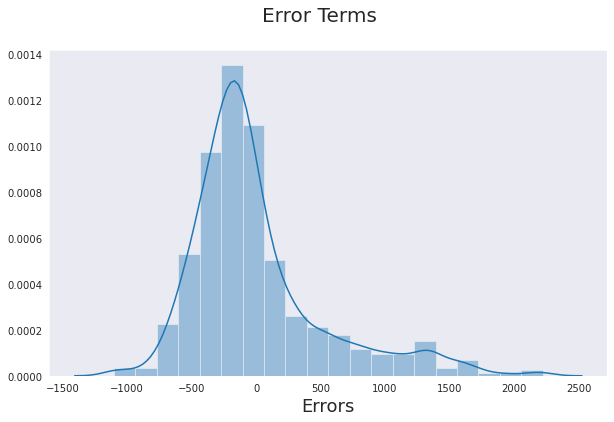

In [104]:
# let's predict on the train set
y_train_cnt = lr4.predict(X_train_lm)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(10,6))
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)       

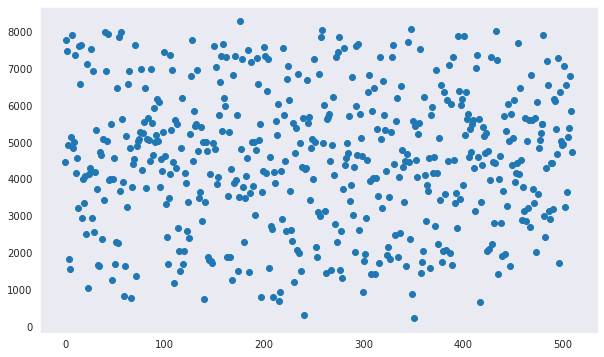

In [125]:
# Plot the scatter of the error terms
fig = plt.figure(figsize=(10,6))
plt.scatter(range(len(y_train_cnt)), y_train_cnt)
plt.show()

Though residual is not centered at exact zero (it's close to zero) but the other factors seems to be right for the model building and lets consider this as our final model

## Making Predictions Using the Final Model

In [107]:
# Prediction on the test set
y_test = df_test.pop('cnt')
X_test = df_test[['registered', 'yr','temp','windspeed','weathersit','hum','holiday']]

In [108]:
# Adding constant variable to test dataframe
X_test_m4 = sm.add_constant(X_test)

# Making predictions using the fourth model
y_pred_m4 = lr4.predict(X_test_m4)

In [126]:
lr4.rsquared

0.9265684772610379

In [110]:
r2_score(y_test, y_pred_m4)

0.9178868799093145

We can see r2_score is very close to the trained model and thus we can say confidently our model is not-overfit and it's generalized one for the further predictions

Text(0, 0.5, 'y_pred')

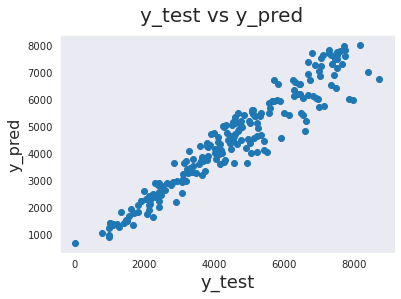

In [111]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_m4)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

Also, when we plot we can see a clear strong correlation between y_pred and y_test

## RFE Model

### Model-1 with 7 features

In [112]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

# create the RFE model and select 7 attributes
rfe = RFE(model, 7)
rfe.fit(X_train, y_train)

# summarize the selection of the attributes
columns_7 = [each[0] for each in list(zip(X_train.columns, rfe.support_, rfe.ranking_)) if each[1] == True]

In [113]:
# Adding constant variable to test dataframe
X_train_lm = sm.add_constant(X_train[columns_7])

# Making predictions using the fourth model
lr9 = sm.OLS(y_train, X_train_lm).fit()

lr9.params

const         4.250000e+02
holiday       2.228262e-11
temp         -1.148237e-11
atemp         1.546141e-11
hum           8.697043e-12
windspeed     4.320100e-12
casual        3.401000e+03
registered    6.530000e+03
dtype: float64

In [114]:
print(lr9.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.874e+29
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:49:00   Log-Likelihood:                 11869.
No. Observations:                 511   AIC:                        -2.372e+04
Df Residuals:                     503   BIC:                        -2.369e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        425.0000   6.18e-12   6.88e+13      0.0

In [115]:
check_vif(X_train_lm)

,Features,VIF
3,atemp,50.28
2,temp,49.60
0,const,49.06
7,registered,1.59
6,casual,1.52
5,windspeed,1.24
4,hum,1.22
1,holiday,1.03


Thats not a good model but with many insignificant features and multicollinearity issues

### Model-2 with 10 features

In [116]:
model = LinearRegression()
model = model.fit(X_train, y_train)

# create the RFE model and select 10 attributes
rfe = RFE(model, 10)
rfe.fit(X_train, y_train)

# summarize the selection of the attributes
columns_10 = [each[0] for each in list(zip(X_train.columns, rfe.support_, rfe.ranking_)) if each[1] == True ]

# Adding constant variable to test dataframe
X_train_lm = sm.add_constant(X_train[columns_10])

# Making predictions using the fourth model
lr10 = sm.OLS(y_train, X_train_lm).fit()

lr10.params

const         4.250000e+02
yr           -1.193712e-12
holiday      -2.455636e-11
weekday      -3.552714e-12
weathersit   -5.684342e-14
temp          9.094947e-13
atemp        -6.821210e-12
hum          -3.296918e-12
windspeed    -4.092726e-12
casual        3.401000e+03
registered    6.530000e+03
dtype: float64

In [117]:
print(lr10.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.554e+29
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:50:29   Log-Likelihood:                 11986.
No. Observations:                 511   AIC:                        -2.395e+04
Df Residuals:                     500   BIC:                        -2.390e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        425.0000   5.05e-12   8.41e+13      0.0

In [118]:
check_vif(X_train_lm)

,Features,VIF
0,const,51.56
6,atemp,50.81
5,temp,49.84
10,registered,3.35
1,yr,2.27
7,hum,1.86
4,weathersit,1.78
9,casual,1.68
8,windspeed,1.31
3,weekday,1.05


Thats not a good model but with many insignificant features and multicollinearity issues

## Conclusion

Created features: 
    
    1. casual/registered feature didn't seem to work well
    2. existing features worked very well in deciding good model
    3. Current model can be improved on permutation of features manually as RFE didn't seem to work 